# INF-475: Modelamiento Estocástico y Simulación
## Tarea 2: ARIMA - SARIMA 
### Daniel San Martín

Módulos y funciones de uso comun.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import warnings
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.gofplots import qqplot
from scipy.optimize import brute

plt.style.use('bmh')
np.random.seed(666)
warnings.filterwarnings("ignore")

In [2]:
def acf_pacf(serie, lags_=50):
    fig, axes = plt.subplots(1, 2)
    plot_acf(serie, lags=lags_, ax=axes[0])
    plot_pacf(serie, lags=lags_, ax=axes[1])
    fig.set_size_inches(16, 4)
    plt.show()

In [3]:
def residual_test(residuals):
    lb = acorr_ljungbox(residuals, lags=30)[1]
    nrm = stats.normaltest(residuals)[1]
    print("Test de Ljung-Box: ", np.all(lb > 0.05))
    print("Test normalidad: ", nrm > 0.05)

In [4]:
def residual_plots(residuals):
    residuals = pd.Series(residuals, name="Residuos")
    residual_test(residuals)
    fig, axes = plt.subplots(2, 2)
    residuals.plot(ax=axes[0, 0])
    residuals.hist(ax=axes[0, 1])
    #residuals.plot(kind='kde', ax=axes[0, 1])
    qqplot(residuals, ax=axes[1, 0])
    plot_acf(residuals, lags=20, ax=axes[1, 1])
    fig.set_size_inches(16, 8)
    plt.show()

In [5]:
def arima_search(order, *params):
    try:
        fit = ARIMA(params, order=order).fit()
        return fit.aic
    except: 
        return np.inf

In [6]:
def arima_params(serie, pmax=5, dmax=2, qmax=5):
    #grid_arima = (slice(0, pmax, 1), slice(0, dmax, 1), slice(1, qmax, 1))
    grid_arima = (slice(1, 4, 1), slice(0, 2, 1), slice(1, 4, 1))
    #sol_arima = brute(arima_search, grid_arima, args=(serie.astype('float64')), finish=None)
    sol_arima = brute(arima_search, grid_arima, args=(serie), finish=None)
    print("Parameters: ({0})".format(",".join(map(str, map(int, sol_arima)))))

### Exploración de los datos

Primero cargamos los datos, revisamos estadísticas generales y graficamos la serie.

In [7]:
df = pd.read_csv('data/river_flows.csv', header=None, names=['date', 'flows'])

In [8]:
df.head()

,date,flows
0,1913-01-31,485
1,1913-02-28,1150
2,1913-03-31,4990
3,1913-04-30,6130
4,1913-05-31,4780


In [9]:
df.describe()

,flows
count,946.000000
mean,2708.573996
std,2123.234239
min,482.000000
25%,1010.000000
50%,1915.000000
75%,3947.500000
max,10800.000000


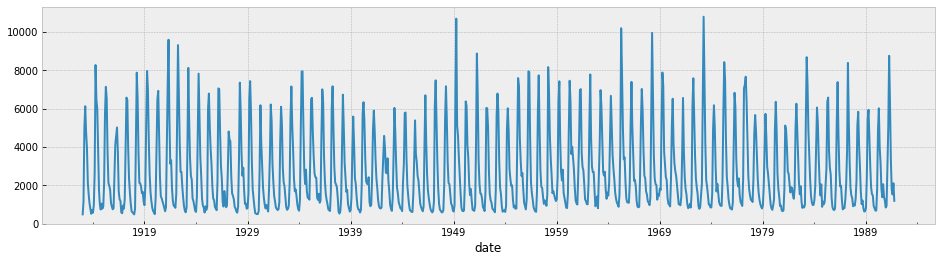

In [10]:
df.reset_index(inplace=True)
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
serie = pd.Series(df['flows'])#['flows'].values, index=df['date'])
serie.plot(figsize=(16, 4))
plt.show()

#### Gráfico de Autocorrelación y Autocorrelación Parcial

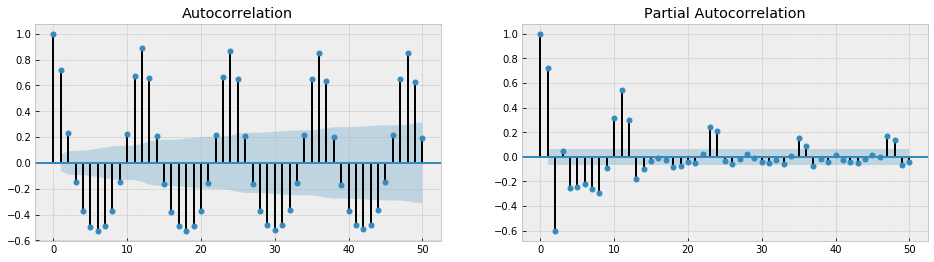

In [11]:
acf_pacf(serie)

De los gráficos anteriores podemos notar el comportamiento *estacional* de la serie, pero no permiten asegurar la condición de *estacionariedad* para utilizar un modelo **ARIMA** directamente.

#### Modelo Ingenuo

Realizamos una descomposición de la serie, suponiendo un modelo ingenuo aditivo.

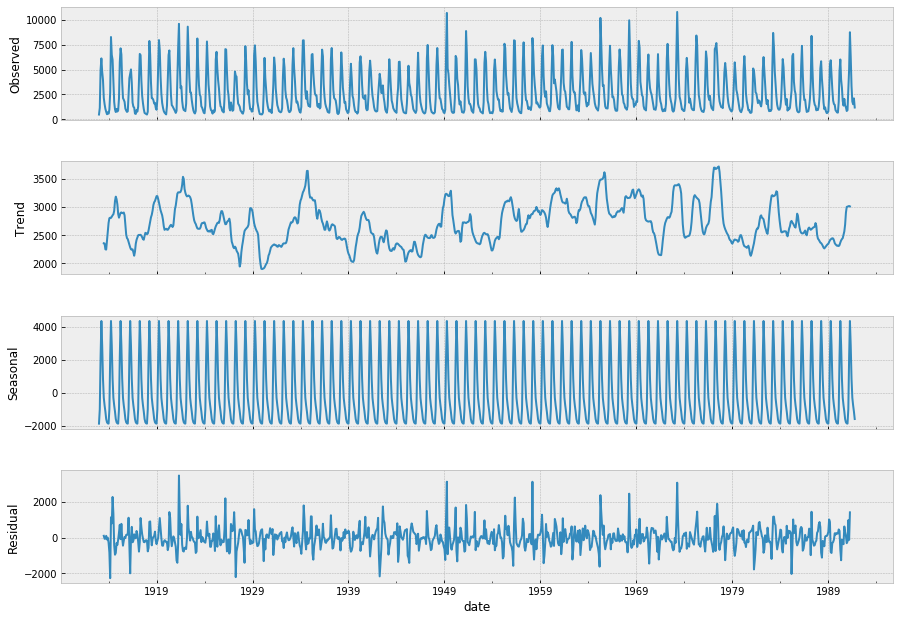

In [12]:
decomp_serie = seasonal_decompose(serie)
fig = decomp_serie.plot()
fig.set_size_inches(14,10)
plt.show()

Ahora, realizaremos un análisis de la serie removiendo el componente *estacional*.

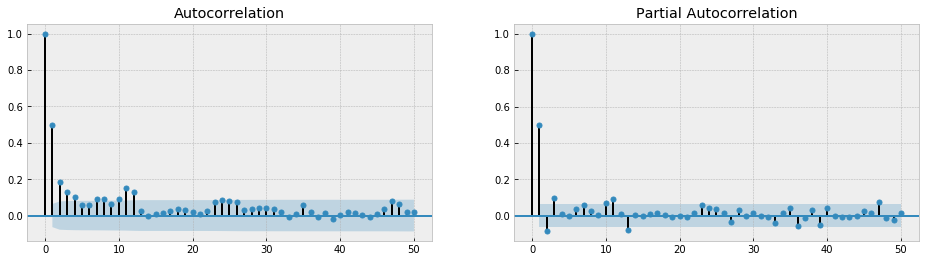

In [13]:
y = serie - decomp_serie.seasonal
acf_pacf(y)

Notamos ahora que el gráfico *ACF* no decae de forma lenta lo que nos permite suponer que la nueva serie es *estacionaria*. Además, analizando el *ACF* vemos que decae exponencial y que el *PACF* corta después del lag 1 o lag 3, por ende los dos modelos propuestos son $ARIMA(1,0,0)$ y $ARIMA(3,0,0)$.

### Modelos ARIMA

##### ARIMA(1,0,0)

In [14]:
arima_1 = ARIMA(serie.astype('float64'), order=(1, 0, 0))
arima_1_fit = arima_1.fit(disp=0)
print(arima_1_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  flows   No. Observations:                  946
Model:                     ARMA(1, 0)   Log Likelihood               -8238.629
Method:                       css-mle   S.D. of innovations           1464.956
Date:                Wed, 22 Aug 2018   AIC                          16483.259
Time:                        21:32:25   BIC                          16497.816
Sample:                    01-31-1913   HQIC                         16488.806
                         - 10-31-1991                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2699.0676    171.694     15.720      0.000    2362.554    3035.581
ar.L1.flows     0.7233      0.022     32.255      0.000       0.679       0.767
                                    Roots       

Test de Ljung-Box:  False
Test normalidad:  False


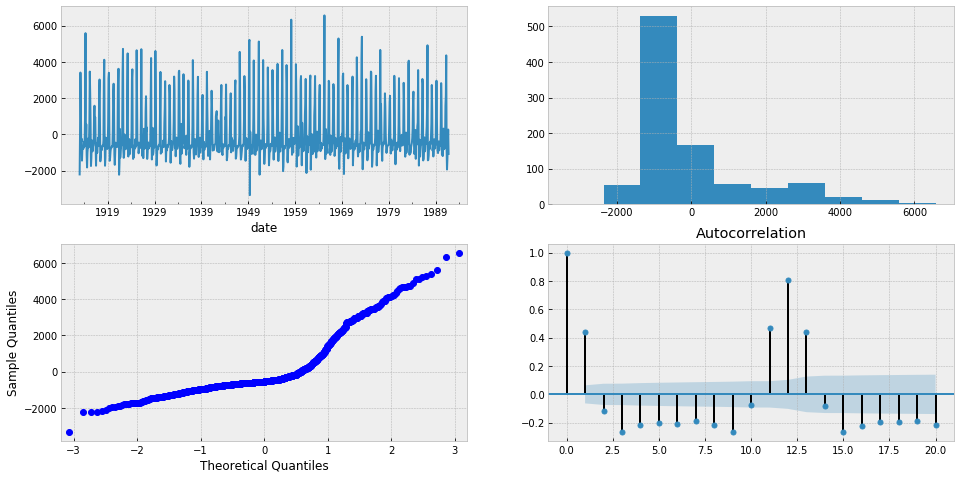

In [15]:
residual_plots(arima_1_fit.resid)

##### ARIMA(3, 0, 0)

In [16]:
arima_2 = ARIMA(serie.astype('float64'), order=(3, 0, 0))
arima_2_fit = arima_2.fit(disp=0)
print(arima_2_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  flows   No. Observations:                  946
Model:                     ARMA(3, 0)   Log Likelihood               -8022.469
Method:                       css-mle   S.D. of innovations           1165.141
Date:                Wed, 22 Aug 2018   AIC                          16054.938
Time:                        21:32:26   BIC                          16079.200
Sample:                    01-31-1913   HQIC                         16064.184
                         - 10-31-1991                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2706.8609     89.393     30.280      0.000    2531.653    2882.069
ar.L1.flows     1.1879      0.033     36.546      0.000       1.124       1.252
ar.L2.flows    -0.6564      0.046    -14.320    

Test de Ljung-Box:  False
Test normalidad:  False


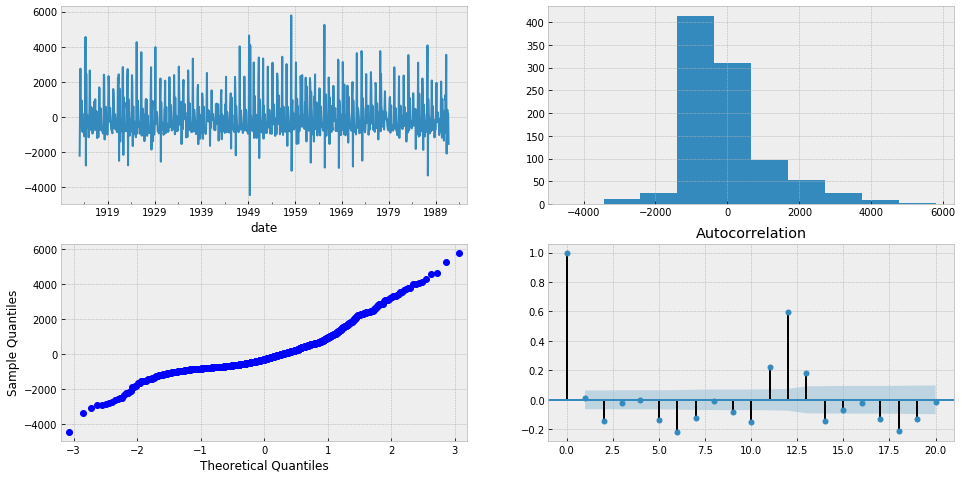

In [17]:
residual_plots(arima_2_fit.resid)

In [18]:
arima_3 = ARIMA(serie.astype('float64'), order=(12, 0, 0))
arima_3_fit = arima_3.fit(disp=0)
print(arima_3_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  flows   No. Observations:                  946
Model:                    ARMA(12, 0)   Log Likelihood               -7600.081
Method:                       css-mle   S.D. of innovations            742.255
Date:                Wed, 22 Aug 2018   AIC                          15228.162
Time:                        21:32:52   BIC                          15296.094
Sample:                    01-31-1913   HQIC                         15254.051
                         - 10-31-1991                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2704.3103     77.439     34.922      0.000    2552.533    2856.088
ar.L1.flows      0.6127      0.031     19.779      0.000       0.552       0.673
ar.L2.flows     -0.3662      0.035    -10.32

Test de Ljung-Box:  False
Test normalidad:  False


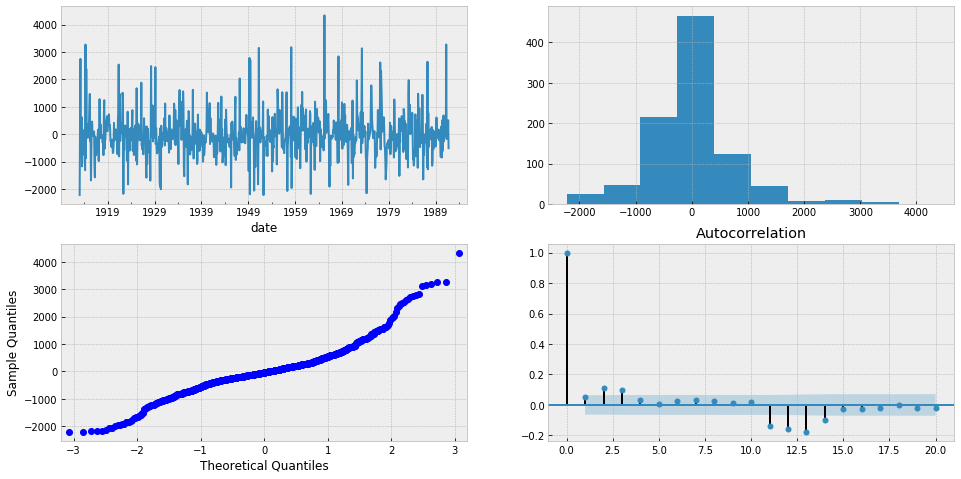

In [19]:
residual_plots(arima_3_fit.resid)

In [20]:
#grid_arima = (slice(1, 4, 1), slice(0, 2, 1), slice(1, 4, 1))
grid_arima = (slice(0, 4, 1), slice(0, 2, 1), slice(0, 4, 1))
sol_arima = brute(arima_search, grid_arima, args=(serie.astype('float64')), finish=None)
#sol_arima = brute(arima_search, grid_arima, args=(serie), finish=None)
print("Parameters: ({0})".format(",".join(map(str, map(int, sol_arima)))))

Parameters: (3,0,3)


In [21]:
arima_4 = ARIMA(serie.astype('float64'), order=(3, 0, 3))
arima_4_fit = arima_4.fit(disp=0)
print(arima_4_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  flows   No. Observations:                  946
Model:                     ARMA(3, 3)   Log Likelihood               -7843.701
Method:                       css-mle   S.D. of innovations            961.060
Date:                Wed, 22 Aug 2018   AIC                          15703.402
Time:                        21:33:13   BIC                          15742.220
Sample:                    01-31-1913   HQIC                         15718.196
                         - 10-31-1991                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2698.7991     56.001     48.192      0.000    2589.040    2808.559
ar.L1.flows     1.8682      0.006    326.374      0.000       1.857       1.879
ar.L2.flows    -1.2362      0.010   -125.183    

Test de Ljung-Box:  False
Test normalidad:  False


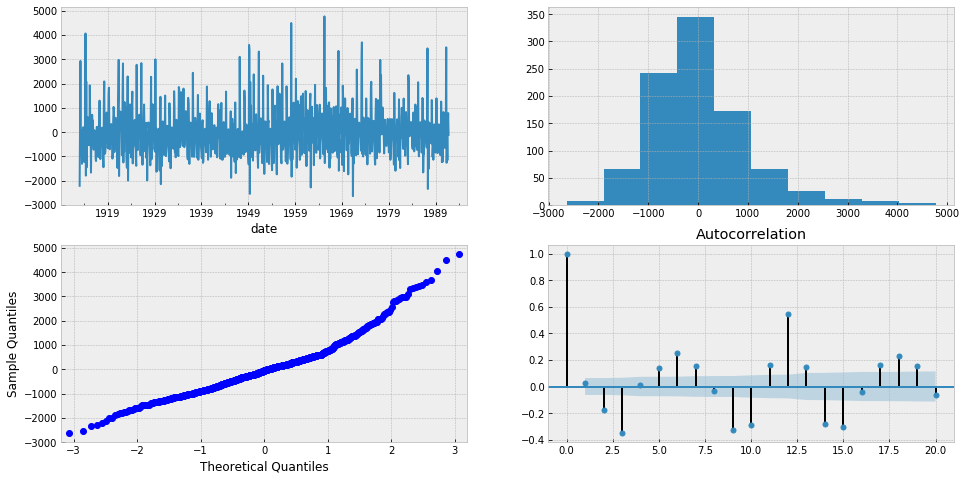

In [22]:
residual_plots(arima_4_fit.resid)

De acuerdo a los test de Ljung-Box, de normalidad y análisis gráfico de los residuos se puede concluir que ninguno de los modelos $ARIMA$ propuestos son capaces de describir el comportamiento de los datos. En la Figura 5 se presenta el mejor residuo obtenido. Se aprecia en el correlograma que no hay evidencia suficiente para suponer que el residuo es un ruido, por esto no podemos validar directamente el modelo.

#### Diferenciando la Serie

In [23]:
serie_diff = pd.Series(np.diff(serie, n=12), name="Serie Diff")

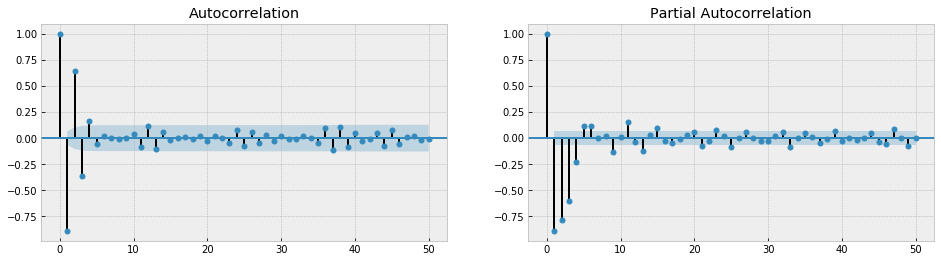

In [24]:
acf_pacf(serie_diff)

In [25]:
arima_5 = ARIMA(serie_diff.astype('float64'), order=(4, 0, 0))
arima_5_fit = arima_5.fit(disp=0)
print(arima_5_fit.summary())

                              ARMA Model Results                              
Dep. Variable:             Serie Diff   No. Observations:                  934
Model:                     ARMA(4, 0)   Log Likelihood              -11893.763
Method:                       css-mle   S.D. of innovations          81688.828
Date:                Wed, 22 Aug 2018   AIC                          23799.526
Time:                        21:33:15   BIC                          23828.563
Sample:                             0   HQIC                         23810.599
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -11.6653    267.119     -0.044      0.965    -535.209     511.878
ar.L1.Serie Diff    -2.7243      0.024   -113.612      0.000      -2.771      -2.677
ar.L2.Serie Diff    -3.3750 

### SARIMA

Para mejorar los resultados del modelo anterior, se propone utilizar un modelo $SARIMA$ dada la componente estacional presentada en los datos. Lo primero es notar que esta componente se repite de forma anual, y con datos mensuales definimos el valor de $s=12$. Tendiendo en cuenta esto, debemos diferenciar al menos 1 vez para construir la serie $x_{13}-x_1, x_{25}-x_2, ..$ por lo tanto con $D=1$ obtenemos la siguiente serie:

In [26]:
serie_shifted = pd.Series(serie.shift(12) - serie).dropna()

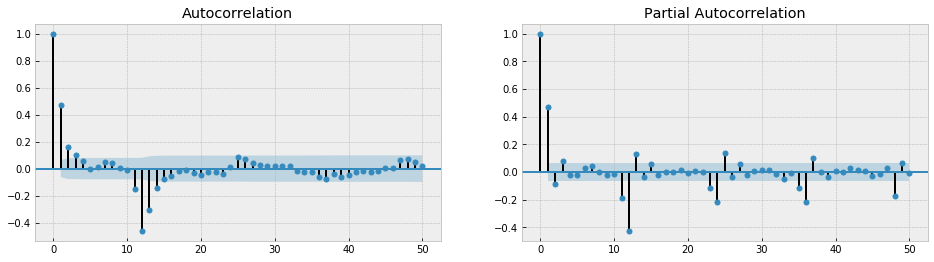

In [27]:
acf_pacf(serie_shifted)

Del gráfico *ACF* vemos que se corta en el lag $Q=2$ y el *PACF* va disminuyendo cada $12$ lags por lo que se puede asumir un $MA$ en la parte estacional. Para la parte no estacional vemos un decaimiento exponencial en el *ACF* mientras que en el *PACF* se corta del lag 3. De esta forma los parámetros determinados para este modelo son: $p=3$, $d=0$, $q=0$, $P=0$, $D=1$, $Q=2$ y $s=12$.

#### $ARIMA(3, 0, 0)\times(0,1,2)_{12}$

In [28]:
sarima_1 = sm.tsa.statespace.SARIMAX(serie,
                                order=(3, 0, 0),
                                seasonal_order=(0,1,2,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

sarima_model_1 = sarima_1.fit()
sarima_model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              flows   No. Observations:                  946
Model:             SARIMAX(3, 0, 0)x(0, 1, 2, 12)   Log Likelihood               -7151.605
Date:                            Wed, 22 Aug 2018   AIC                          14315.210
Time:                                    21:33:23   BIC                          14344.084
Sample:                                01-31-1913   HQIC                         14326.235
                                     - 10-31-1991                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5575      0.022     25.653      0.000       0.515       0.600
ar.L2         -0.1529      0.030     -5.135      0.000      -0.211      -0.095
ar.L3          0.1080      0.040      2.689      0.007       0.029       0.187
ma.S.L12      -0.8922      0.036    -24.669      0.000      -0.963      -0.821
ma.S.L24      -0.1188      0.021     -5.588      0.000      -0.160      -0.077
sigma2      3.787e+05   1.63e+04     23.187      0.000    3.47e+05    4.11e+05
===================================================================================
Ljung-Box (Q):                       32.94   Jarque-Bera (JB):              1177.91
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                             0.72
Prob(H) (two-sided):                  0.99   Kurtosis:                         8.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

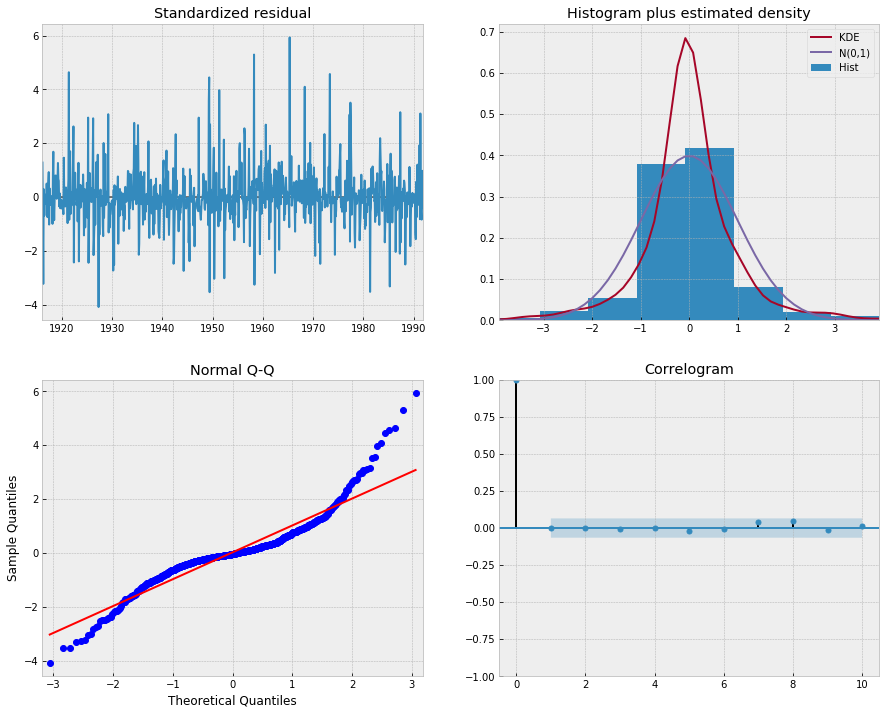

In [29]:
sarima_model_1.plot_diagnostics(figsize=(15, 12))
plt.show()

De acuerdo a las métricas de evaluación notamos una mejora en el modelo en comparación al modelo ARIMA. Sobre la validación del modelo, la evaluación del residuo en la Figura 7 nos permite suponer que el residuo se comporta como un ruido blanco gaussiano, por lo que el modelo es válido para explicar el proceso asociado al fenómeno.

#### Prueba de otros SARIMA

In [30]:
sarima_2 = sm.tsa.statespace.SARIMAX(serie,
                                order=(2,1,2),
                                seasonal_order=(1,1,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

sarima_model_2 = sarima_2.fit()
sarima_model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              flows   No. Observations:                  946
Model:             SARIMAX(2, 1, 2)x(1, 1, 1, 12)   Log Likelihood               -7226.942
Date:                            Wed, 22 Aug 2018   AIC                          14467.884
Time:                                    21:33:31   BIC                          14501.639
Sample:                                01-31-1913   HQIC                         14480.766
                                     - 10-31-1991                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1293      0.232      0.557      0.578      -0.326       0.584
ar.L2          0.0760      0.125      0.608      0.543      -0.169       0.321
ma.L1         -0.6048      0.235     -2.572      0.010      -1.066      -0.144
ma.L2         -0.4197      0.238     -1.765      0.078      -0.886       0.046
ar.S.L12       0.1068      0.022      4.761      0.000       0.063       0.151
ma.S.L12      -1.0001      0.031    -32.213      0.000      -1.061      -0.939
sigma2      3.708e+05    8.4e-08   4.42e+12      0.000    3.71e+05    3.71e+05
===================================================================================
Ljung-Box (Q):                       33.31   Jarque-Bera (JB):              1137.54
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             0.72
Prob(H) (two-sided):                  0.87   Kurtosis:                         8.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.63e+29. Standard errors may be unstable.
"""

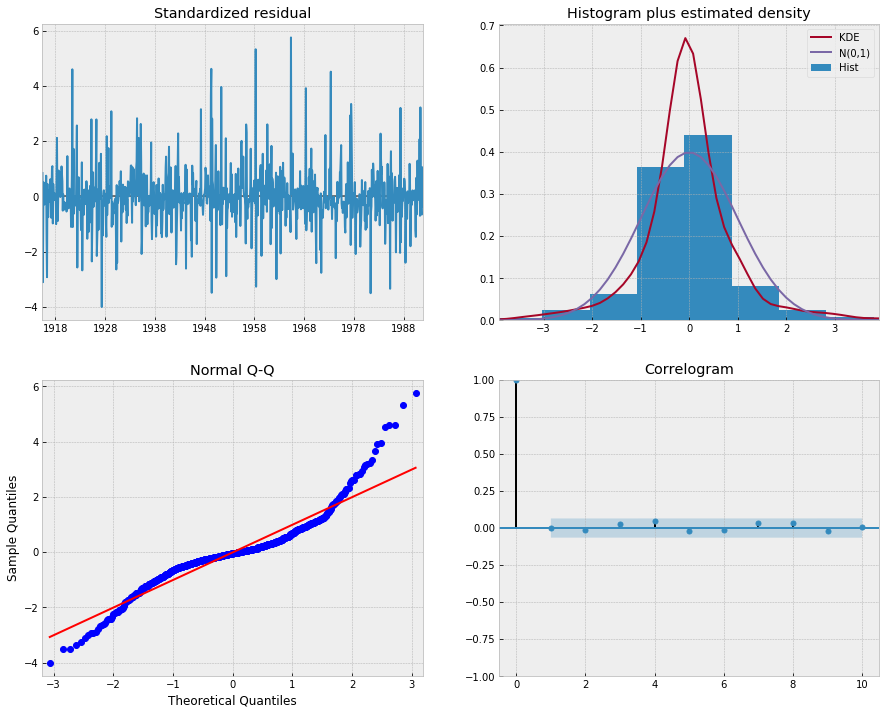

In [31]:
sarima_model_2.plot_diagnostics(figsize=(15, 12))
plt.show()

In [32]:
sarima_3 = sm.tsa.statespace.SARIMAX(serie,
                                order=(2,0,2),
                                seasonal_order=(1,1,0,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

sarima_model_3 = sarima_3.fit()
sarima_model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              flows   No. Observations:                  946
Model:             SARIMAX(2, 0, 2)x(1, 1, 0, 12)   Log Likelihood               -7374.170
Date:                            Wed, 22 Aug 2018   AIC                          14760.340
Time:                                    21:33:34   BIC                          14789.286
Sample:                                01-31-1913   HQIC                         14771.386
                                     - 10-31-1991                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6513      0.467      1.394      0.163      -0.265       1.567
ar.L2          0.0308      0.175      0.176      0.860      -0.312       0.373
ma.L1         -0.1303      0.469     -0.278      0.781      -1.050       0.790
ma.L2         -0.2424      0.118     -2.062      0.039      -0.473      -0.012
ar.S.L12      -0.4688      0.016    -28.800      0.000      -0.501      -0.437
sigma2      5.365e+05   1.48e+04     36.374      0.000    5.08e+05    5.65e+05
===================================================================================
Ljung-Box (Q):                      134.88   Jarque-Bera (JB):               677.85
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             0.18
Prob(H) (two-sided):                  0.94   Kurtosis:                         7.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

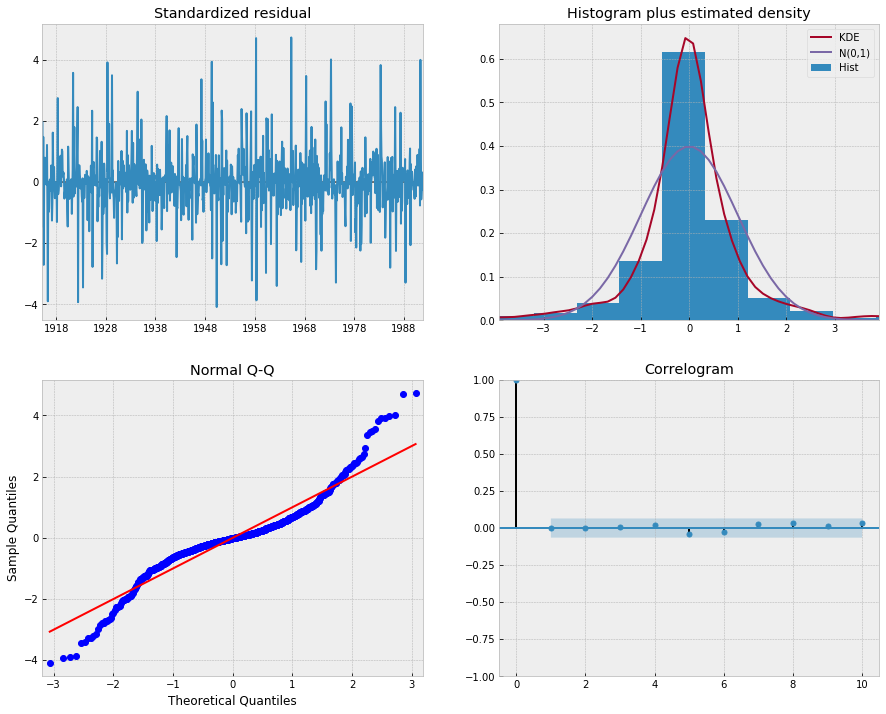

In [33]:
sarima_model_3.plot_diagnostics(figsize=(15, 12))
plt.show()

In [34]:
sarima_4 = sm.tsa.statespace.SARIMAX(serie,
                                order=(3,0,0),
                                seasonal_order=(0,1,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

sarima_model_4 = sarima_4.fit()
sarima_model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              flows   No. Observations:                  946
Model:             SARIMAX(3, 0, 0)x(0, 1, 1, 12)   Log Likelihood               -7254.321
Date:                            Wed, 22 Aug 2018   AIC                          14518.643
Time:                                    21:33:38   BIC                          14542.770
Sample:                                01-31-1913   HQIC                         14527.849
                                     - 10-31-1991                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5537      0.021     25.987      0.000       0.512       0.595
ar.L2         -0.1466      0.029     -5.040      0.000      -0.204      -0.090
ar.L3          0.1105      0.039      2.845      0.004       0.034       0.187
ma.S.L12      -0.9658      0.011    -88.565      0.000      -0.987      -0.944
sigma2      3.947e+05   9731.334     40.561      0.000    3.76e+05    4.14e+05
===================================================================================
Ljung-Box (Q):                       46.44   Jarque-Bera (JB):              1164.69
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                             0.79
Prob(H) (two-sided):                  0.67   Kurtosis:                         8.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

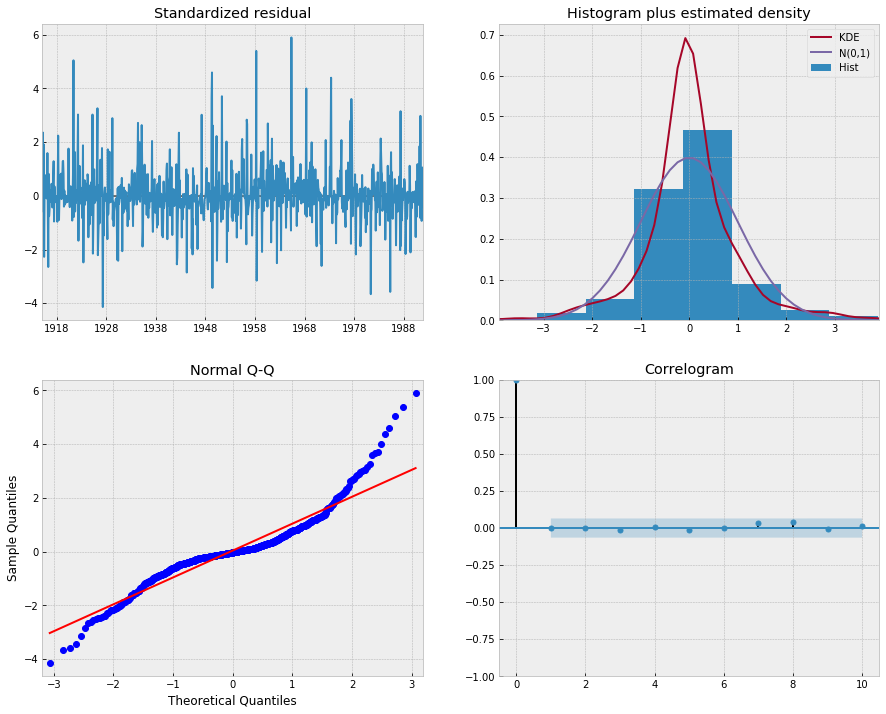

In [35]:
sarima_model_4.plot_diagnostics(figsize=(15, 12))
plt.show()

### Predicciones

In [36]:
arima_1_forecast = arima_1_fit.predict(start=len(y), end=len(y)+5)

#### Utilizando el modelo ARIMA

In [37]:
pred, sterr, ci = arima_3_fit.forecast(steps=6)

In [38]:
a3m = pd.Series(pred, index=arima_1_forecast.index)

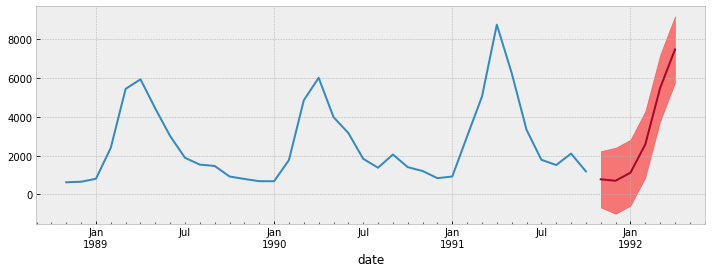

In [39]:
plt.figure(figsize=(12, 4))
serie.tail(36).plot()
a3m.plot()
plt.fill_between(a3m.index, ci[:,0], ci[:,1], color='r', alpha=.5)
plt.show()

#### Utilizando el modelo SARIMA

In [41]:
s1m = sarima_model_1.get_prediction(start='1991-11-30', end='1992-04-30', dynamic=False)
s1m_ci = s1m.conf_int()
s1m_pred = s1m.predicted_mean

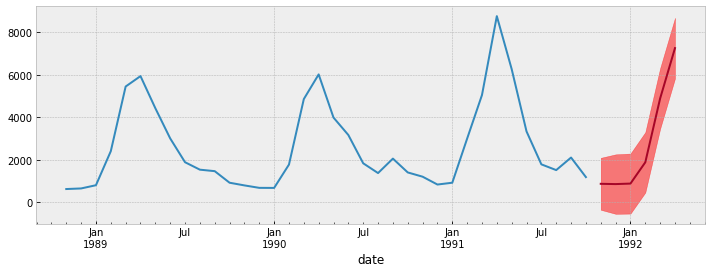

In [44]:
plt.figure(figsize=(12, 4))
serie.tail(36).plot()
s1m_pred.plot()
plt.fill_between(s1m_pred.index, s1m_ci.iloc[:, 0], s1m_ci.iloc[:, 1], color='r', alpha=.5)
plt.show()

Podemos notar que cualitativamente son muy parecidas las predicciones, pero el intervalo de confianza asociado al modelo $SARIMA$ nos permite estimar con mayor certeza. Además, no es posible confiar en su totalidad de los resultados del modelo $ARIMA$ dado que en la pregunta 1 no pudo ser validado con el análisis de los residuos asociados a este.

### Realizaciones

#### Probando con ARIMA

In [45]:
arparams = arima_1_fit.arparams
maparams = arima_1_fit.maparams
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag
ransam = sm.tsa.arma_generate_sample(ar, ma, 1000)

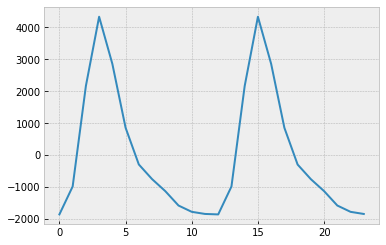

In [46]:
plt.plot(ransam[-24:]+decomp_serie.seasonal.head(24).values)
plt.show()

#### Probando con SARIMA

In [47]:
arpar1 = sarima_model_1.params[0:3].values
maSpar1 = sarima_model_1.params[3:5].values
ar1 = np.r_[1, -arpar1] # add zero-lag and negate
ma1 = np.r_[1, []] # add zero-lag
ar2 = np.r_[1, []] # add zero-lag and negate
ma2 = np.r_[1, maSpar1] # add zero-lag
ransam1 = sm.tsa.arma_generate_sample(ar1, ma1, 1000)
ransam2 = sm.tsa.arma_generate_sample(ar2, ma2, 1000)

In [48]:
sarima = ransam1 * ransam2

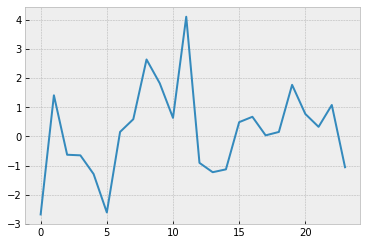

In [49]:
plt.plot(sarima[-24:])
plt.show()

#### Generando simulaciones con SARIMA

In [77]:
sarima_model_1.params

ar.L1            0.557455
ar.L2           -0.152860
ar.L3            0.107957
ma.S.L12        -0.892232
ma.S.L24        -0.118788
sigma2      378685.740969
dtype: float64

In [50]:
reali = np.zeros((500, 24)) 

In [51]:
for i in range(500):
     reali[i,:] = sarima_model_1.simulate(24)[-24:]

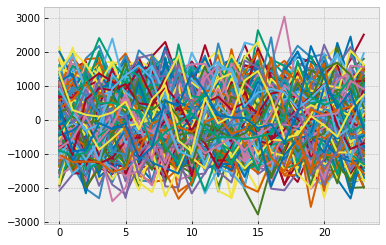

In [53]:
for i in range(500):
    plt.plot(reali[i])
plt.show()

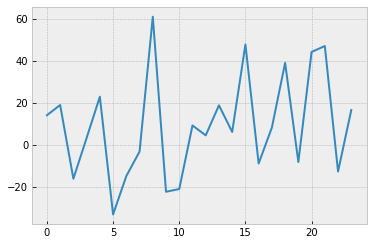

In [59]:
plt.plot(reali.mean(axis=0))
plt.show()

In [60]:
rm = reali.mean(axis=0)

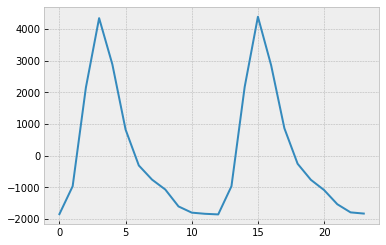

In [61]:
plt.plot(rm + decomp_serie.seasonal.values[:24])
plt.show()

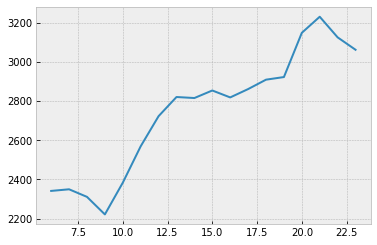

In [62]:
plt.plot(rm + decomp_serie.trend.values[:24])
plt.show()

No es posible obtener valores mayor a 8000 con los datos simulados.

In [ ]:
sarima_model_1.params.values

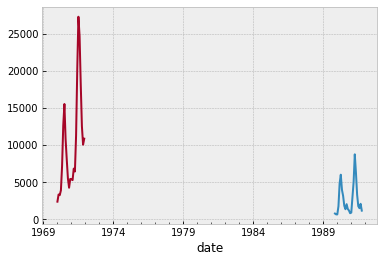

In [64]:
serie.tail(24).plot()
simu = pd.Series(sarima_model_1.simulate(24, initial_state=serie.tail(37).values), index)
plt.plot()
plt.show()

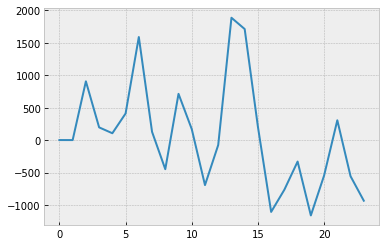

In [65]:
plt.plot(sarima_model_1.simulate(24, initial_state=np.ones(37)))
plt.show()

In [111]:
reali_test = np.zeros((500, 24)) 
for i in range(500):
    reali_test[i,:] = sarima_model_1.simulate(500, initial_state=serie.tail(37).values)[-24:]

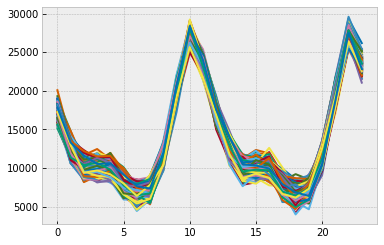

In [112]:
for i in range(500):
    #reali_test[i,:] = sarima_model_1.simulate(24, initial_state=np.zeros(37))#, initial_state=serie.tail(37).values)#[-24:]
    plt.plot(reali_test[i])
plt.show()

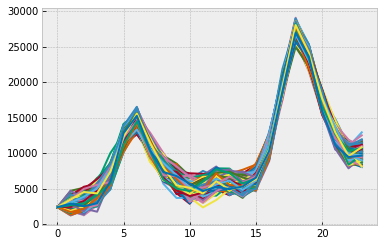

In [76]:
for i in range(500):
    plt.plot(reali_test[i])
plt.show()

In [104]:
index_24 = arima_1_fit.predict(start=len(serie), end=len(serie)+23).index

In [113]:
rm_test  = pd.Series(reali_test.mean(axis=0), index=index_24)

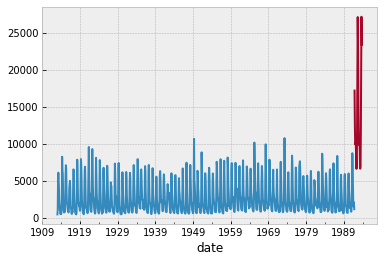

In [114]:
serie.plot()
rm_test.plot()
plt.show()